# Load libraries and files

In [43]:
%run ../python/GAN.py
%run ../python/SceneDef.py

import os
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

import cv2
import glob
import tensorflow as tf

tf.keras.backend.set_floatx('float32')

#from GAN import SceneGaussian2D, GAN
#from SceneDef import PrintDistribution

/Users/jodon/Work/01_codes/01_research_epfl/LinearExplorator/python/GAN.py:42: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(self.mean, self.cov, samples)


# Input settings

In [44]:
N_SAMPLES   = 2**14
BATCH_SIZE  = 2**5
EPOCHS      = 10
LATENT_DIM  = 2**10


# Weights in front of the loss for the training
weightCounterfeit = 1.00
weightSpread      = 0.00
weightDiversity   = 0.00
weights = [weightCounterfeit, weightSpread, weightDiversity]

loadModel = False

dirname           = "GANTrainingRobin"
pathToImages      = "../output/{}".format(dirname)
checkpoint_dir    = '../models/{}'.format(dirname)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Generate training dataset 

## 2D Gaussian distribution generation

- The gaussian cloud can be tilted, compressed or dilated along an axis by changing its covariance matrix.
- There is a convenient rescaling done here: `posSamples = scene.xy_samples * 0.07`.

In [45]:
mean   = [3.0, 0.0]
cov    = [[3, 0], [0, 1]]
scene = SceneGaussian2D(mean, cov, N_SAMPLES)
posSamples = scene.xy_samples * 0.07

## Training dataset generation

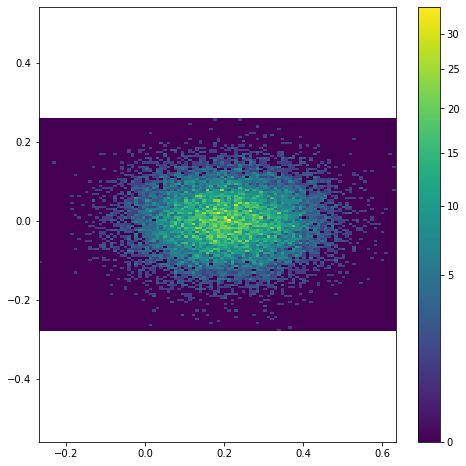

In [46]:
#polarSamples = CartesianToPolar(posSamples)
train_dataset = tf.data.Dataset.from_tensor_slices(posSamples).shuffle(N_SAMPLES).batch(BATCH_SIZE)
#train_dataset = tf.data.Dataset.from_tensor_slices(polarSamples).shuffle(N_SAMPLES).batch(BATCH_SIZE)
PrintDistribution(posSamples)

# Create the GAN

In [47]:
generator_optimizer     = tf.keras.optimizers.Adam(lr=9.0E-4, amsgrad=False)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1.2E-3, amsgrad=False)
gan = GAN(N_SAMPLES, BATCH_SIZE, EPOCHS, LATENT_DIM, scene,
          generator_optimizer, discriminator_optimizer, weights, activation='tanh',
          is_polar=False)

## Get samples from the generator

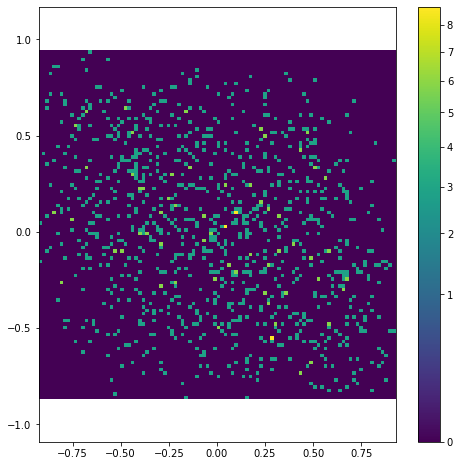

In [48]:
generated_samples = gan.get_generator_samples()
PrintDistribution(generated_samples)

## Get the decision from the discriminator

In [49]:
decision = gan.discriminator(generated_samples)
print(tf.math.reduce_mean(decision))


tf.Tensor(0.0008596546, shape=(), dtype=float32)


# Monitoring the training

## Creating a checkpoints manager

Not needed for now

In [50]:
manager = None

## Generate some examples

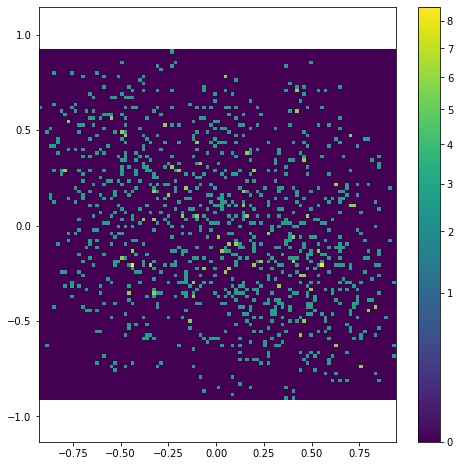

In [51]:
PrintDistribution(gan.seed_samples)

# Train the generator and discriminator

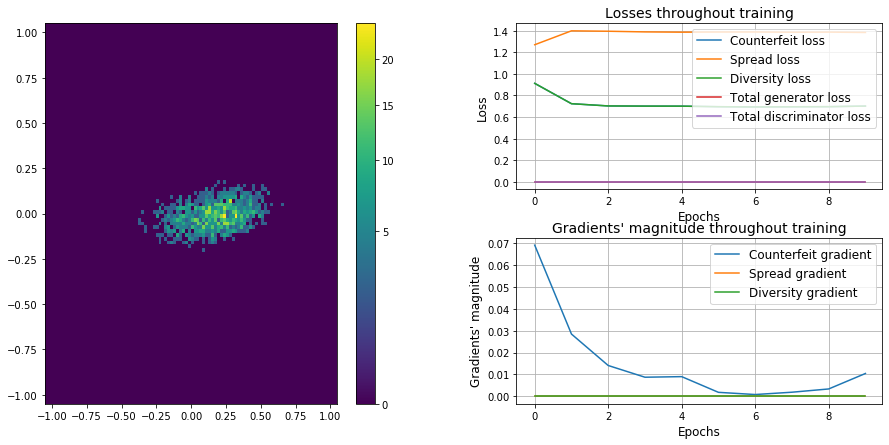

In [52]:
if not loadModel:
    losses = gan.train(dataset        = train_dataset,
                       checkpt_manager= manager,
                       pathToImages   = pathToImages,
                       polar          = False)
    
else:
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [53]:
gan.generator.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                65600     
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               16640     
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0   

In [54]:
gan.discriminator.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                192       
_________________________________________________________________
dropout_21 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0   

# Create an animation

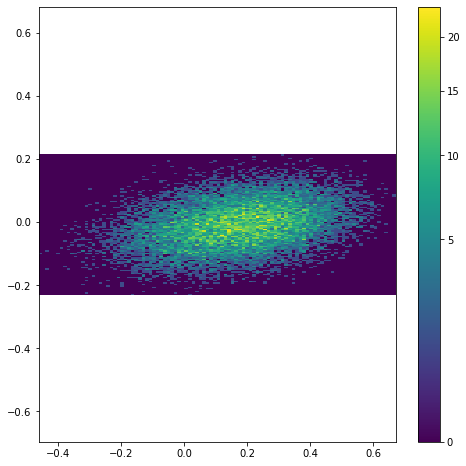

In [55]:
noise = tf.random.normal([N_SAMPLES, LATENT_DIM])
generated_samples = gan.generator(noise, training=False)

#PrintDistribution(PolarToCartesian(generated_samples))
PrintDistribution(generated_samples)

In [56]:
#retval = cv2.VideoWriter_fourcc(*'MP4V')

#if not loadModel:
#    video_name = pathToImages + 'video.mp4'

#    filenames = glob.glob(pathToImages + 'image*.png')
#    filenames = sorted(filenames)
#    frame = cv2.imread(filenames[0])
#    height, width, layers = frame.shape

#    video = cv2.VideoWriter(video_name, retval, 15, (width,height))

#    for image in filenames:
#        video.write(cv2.imread(image))

#    cv2.destroyAllWindows()
#    video.release()